<a href="https://colab.research.google.com/github/nickwan/ufc_data/blob/master/ufc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install adjustText
!pip install shap

In [0]:
import requests
import json
import datetime
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
import warnings
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score

from IPython.display import display, HTML
from adjustText import adjust_text
from tqdm import tqdm_notebook

In [21]:
fighter_details = pd.read_csv('raw_fighter_details.csv')
fighter_details['DOB'].sample(5)
# height = fighter_details['Height'].str.replace('"',"").str.split(r"""'""",expand=True)
# fighter_details['Height_cms'] = height[1].astype(float).div(12).add(height[0].astype(float)).mul(30.48)
# fighter_details['Reach_cms'] = fighter_details['Reach'].str.replace('"','').astype(float).mul(2.54)

105     May 05, 1976
2551    Oct 20, 1979
155     Oct 22, 1991
2649    Nov 20, 1958
2876    Aug 18, 1980
Name: DOB, dtype: object

In [0]:
fighters = pd.read_csv('data.csv')
fighters = fighters.loc[:,['R_fighter', 'B_fighter','R_wins', 
                           'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs', 
                           'R_age','B_age', 'B_wins','B_Height_cms', 
                           'B_Reach_cms', 'B_Weight_lbs']].drop_duplicates()


# r_cols=['R_fighter','R_wins', 'R_Stance', 'R_Height_cms', 
#         'R_Reach_cms', 'R_Weight_lbs', 'R_age']
# b_cols=['B_fighter','B_wins', 'B_Stance', 'B_Height_cms', 
#         'B_Reach_cms', 'B_Weight_lbs', 'B_age']

# fighters = (fighters
#  .loc[:,r_cols]
#  .groupby(r_cols,as_index=False)
#  .first()
#  .reset_index(drop=True)
#  .rename(columns={k:v[2:] for k,v in zip(r_cols,r_cols)})
#  .append(fighters
#          .loc[:,b_cols]
#          .groupby(b_cols,as_index=False)
#          .first()
#          .reset_index(drop=True)
#          .rename(columns={k:v[2:] for k,v in zip(b_cols,b_cols)}),
#          ignore_index=True)).drop_duplicates()

In [6]:
df = pd.read_csv('preprocessed_data.csv')
df.shape

(3592, 160)

In [7]:
df.columns.values

array(['Winner', 'title_bout', 'no_of_rounds', 'B_current_lose_streak',
       'B_current_win_streak', 'B_draw', 'B_avg_BODY_att',
       'B_avg_BODY_landed', 'B_avg_CLINCH_att', 'B_avg_CLINCH_landed',
       'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed', 'B_avg_GROUND_att',
       'B_avg_GROUND_landed', 'B_avg_HEAD_att', 'B_avg_HEAD_landed',
       'B_avg_KD', 'B_avg_LEG_att', 'B_avg_LEG_landed', 'B_avg_PASS',
       'B_avg_REV', 'B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed',
       'B_avg_SIG_STR_pct', 'B_avg_SUB_ATT', 'B_avg_TD_att',
       'B_avg_TD_landed', 'B_avg_TD_pct', 'B_avg_TOTAL_STR_att',
       'B_avg_TOTAL_STR_landed', 'B_longest_win_streak', 'B_losses',
       'B_avg_opp_BODY_att', 'B_avg_opp_BODY_landed',
       'B_avg_opp_CLINCH_att', 'B_avg_opp_CLINCH_landed',
       'B_avg_opp_DISTANCE_att', 'B_avg_opp_DISTANCE_landed',
       'B_avg_opp_GROUND_att', 'B_avg_opp_GROUND_landed',
       'B_avg_opp_HEAD_att', 'B_avg_opp_HEAD_landed', 'B_avg_opp_KD',
       'B_avg_opp_LEG_a

In [8]:
df.shape

(3592, 160)

In [9]:
# join_cols = ['wins','Height_cms', 'Reach_cms','Weight_lbs', 'age']
data = df.merge(fighters,how='outer',indicator=True)
data.shape

(5433, 163)

In [10]:
data['_merge'].value_counts()

both          3302
right_only    1841
left_only      290
Name: _merge, dtype: int64

In [22]:
data['red_wins'].describe()

count    3302.000000
mean        0.635978
std         0.481228
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: red_wins, dtype: float64

In [24]:
data = data.loc[data['_merge']=='both'].reset_index(drop=True)
data['red_wins'] = data['Winner'].replace(['Red','Blue'], [1,0])

((1785, 164), (315, 164))

In [0]:
data2 = data.copy()
data2['red_wins'] = data2['red_wins'].replace([0,1],[1,0])
r2b = {x:f'B_{x[2:]}' for x in data2.columns.values if 'R_' in x[:2]}
b2r = {x:f'R_{x[2:]}' for x in data2.columns.values if 'B_' in x[:2]}
new_col_names = {**r2b,**b2r}
data2 = data2.rename(columns=new_col_names)

In [51]:
data.loc[[2619]]

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,...,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,weight_class_Bantamweight,weight_class_Catch Weight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_Light Heavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Open Weight,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch,R_fighter,B_fighter,_merge,red_wins
2619,Blue,False,3.0,0.0,3.0,0.0,3.0,0.75,10.75,6.0,60.0,16.0,3.0,3.0,70.75,24.25,0.75,0.0,0.0,0.0,0.0,73.75,25.0,0.5075,0.0,0.25,0.0,0.0,76.75,28.0,3.0,1.0,1.25,1.0,2.25,1.0,36.25,10.75,0.5,0.25,...,0.0,0.0,0.0,0.0,2.0,1.0,1.0,4.0,187.96,185.42,230.0,28.0,36.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Mirko Cro Cop,Brendan Schaub,both,0


In [52]:
data2.loc[[2619]]

,Winner,title_bout,no_of_rounds,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_BODY_att,R_avg_BODY_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_KD,R_avg_LEG_att,R_avg_LEG_landed,R_avg_PASS,R_avg_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_att,R_avg_TD_landed,R_avg_TD_pct,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,...,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_age,B_age,weight_class_Bantamweight,weight_class_Catch Weight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_Light Heavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Open Weight,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,B_fighter,R_fighter,_merge,red_wins
2619,Blue,False,3.0,0.0,3.0,0.0,3.0,0.75,10.75,6.0,60.0,16.0,3.0,3.0,70.75,24.25,0.75,0.0,0.0,0.0,0.0,73.75,25.0,0.5075,0.0,0.25,0.0,0.0,76.75,28.0,3.0,1.0,1.25,1.0,2.25,1.0,36.25,10.75,0.5,0.25,...,0.0,0.0,0.0,0.0,2.0,1.0,1.0,4.0,187.96,185.42,230.0,28.0,36.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Mirko Cro Cop,Brendan Schaub,both,1


In [53]:
balanced_data = data.append(data2,ignore_index=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [54]:
test_data = balanced_data.sample(frac=.15)
train_data = balanced_data.loc[(~balanced_data.index.isin(test_data.index.values))]
train_data.shape, test_data.shape

((5613, 165), (991, 165))

In [0]:
red_feats = [x for x in balanced_data.columns.values if '_avg' in x]
target = 'red_wins'

In [0]:
rf = RandomForestClassifier(n_estimators=1000)

In [85]:
rf.fit(train_data.loc[:,red_feats],train_data[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
test_data['pred'] = pd.DataFrame(rf.predict_proba(test_data.loc[:,red_feats]),
                                 index=test_data.index)[1]
test_data['avg'] = test_data['red_wins'].mean()

In [87]:
print(log_loss(test_data['red_wins'], test_data['pred']))
print(log_loss(test_data['red_wins'], test_data['avg']))

0.6669647267469029
0.6925233751942456


In [88]:
print(accuracy_score(test_data['red_wins'], test_data['pred'].round(0)))
print(accuracy_score(test_data['red_wins'], test_data['avg'].round(0)))

0.5852674066599395
0.5176589303733602


In [89]:
logr = LogisticRegression()
logr.fit(train_data.loc[:,red_feats],train_data[target])
test_data['pred'] = pd.DataFrame(logr.predict_proba(test_data.loc[:,red_feats]),
                                 index=test_data.index)[1]
test_data['avg'] = test_data['red_wins'].mean()

print(log_loss(test_data['red_wins'], test_data['pred']))
print(log_loss(test_data['red_wins'], test_data['avg']))
print(accuracy_score(test_data['red_wins'], test_data['pred'].round(0)))
print(accuracy_score(test_data['red_wins'], test_data['avg'].round(0)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6603976323338766
0.6925233751942456
0.6074672048435923
0.5176589303733602


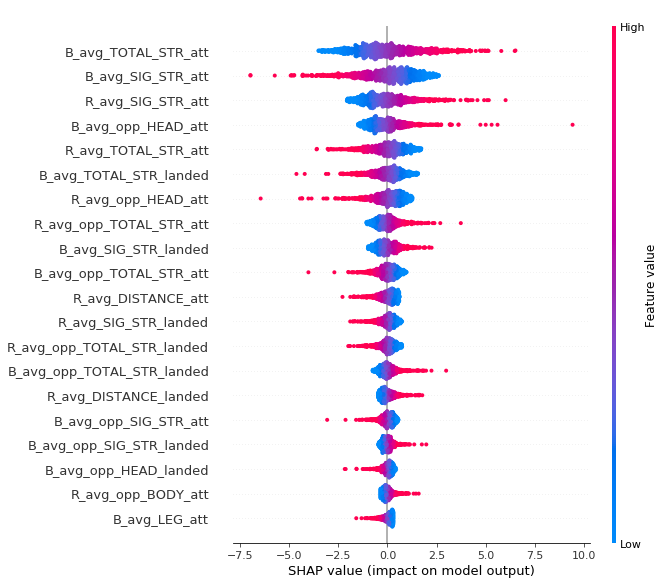

In [91]:
explainer = shap.LinearExplainer(logr, train_data.loc[:,red_feats], feature_dependence="independent")
shap_values = explainer.shap_values(test_data.loc[:,red_feats])
shap.summary_plot(shap_values, test_data.loc[:,red_feats], feature_names=red_feats)

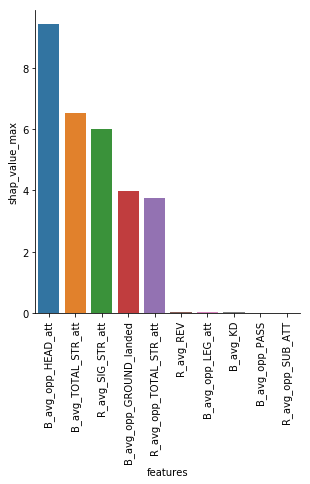

In [114]:
df_shap_ = pd.DataFrame(shap_values,columns=red_feats)
df_shap = df_shap_.mean().to_frame().reset_index().rename(columns={'index':'features',0:'shap_value_mean'})
df_shap = df_shap.merge(df_shap_.median().to_frame().reset_index().rename(columns={'index':'features',0:'shap_value_median'}))
df_shap = df_shap.merge(df_shap_.max().to_frame().reset_index().rename(columns={'index':'features',0:'shap_value_max'}))

DV = 'shap_value_max'
top_and_bot = 5
df_shap = df_shap.sort_values(DV,ascending=False)
sns.catplot(x='features',y=DV,kind='bar',
            data=df_shap.head(top_and_bot).append(df_shap.tail(top_and_bot)))
plt.xticks(rotation=90)
plt.show()